In [1]:
# math, numpy, torch and tqdm
import math
import numpy as np
import torch
from tqdm import tqdm

#SBI
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis

# SciPy
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Constants
torch.manual_seed(0)
np.random.seed(0)
tf = 50
dt = 0.01
N = round(tf/dt)
t = np.arange(0, tf, dt)

tspan = [0, tf]
c0 = [0, 0]

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 600

In [3]:
def system(t, z, k1, k2, k3, k4, Ac, xi):
    """
    This function returns the ODE system.

    Args:
        t (paramter): time (optional)
        z (list): state variables
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant
    
    Returns:
        list: ODE system
    """
    x, y = z
    return [- k1*x - k2*y + Ac, k3*x - k4*y + xi*Ac]

def simulator(k1, k2, k3, k4, Ac, xi):
    """Solves the ODE system using the SciPy solver.

    Args:
        k1 (float): k1 constant
        k2 (float): k2 constant
        k3 (float): k3 constant
        k4 (float): k4 constant
        Ac (float): Ac constant
        xi (float): xi constant

    Returns:
        The solution of the ODE system.
    """
    return solve_ivp(system, tspan, c0, args = (k1, k2, k3, k4, Ac, xi), t_eval = t) # Paso explicito

In [4]:
# True parameters and respective labels
true_params_nfbl = np.array([1, 1, 0.05, 0.05, 1, 0])
labels_params = [r"$k_{1}$", r"$k_{2}$", r"$k_{3}$", r"$k_{4}$", r"$A_{c}$", r"$\xi$"]

true_params_iffl = np.array([1, 1, 0, 0.2, 1, 0.1])
labels_params_iffl = [r"$K_{1}$", r"$K_{2}$", r"$K_{3}$", r"$kK_{4}$", r"$A_{c}$", r"$\xi$"]

observation_trace = simulator(true_params_nfbl[0], true_params_nfbl[1], true_params_nfbl[2], true_params_nfbl[3], true_params_nfbl[4], true_params_nfbl[5])

def calculate_summary_statistics(x, dt):
    """Calculates the summary statistics (attributes) of the system.

    Args:
        x (array): The system state variable.

    Returns:
        A numpy array with the summary statistics (attributes) of the system
    """
    
    if np.any(x < 0): # Not a valid simulation
        return np.array([math.nan, math.nan, math.nan, math.nan])
    else:
        # Check if the system presents oscillations
        peaks, _ = find_peaks(x, height=0.1, prominence=0.1)
        if len(peaks) > 1:
            # The system has oscillations
            return np.array([math.nan, math.nan, math.nan, math.nan])
        
        # Peak
        # I don't want to use find_peaks for this since I have the min height and min prominence
        Xpeak = np.max(x)
        Tpeak = np.where(x == Xpeak)[0][0] * dt
        
        tau1 = np.where(x >= Xpeak*0.63)[0][0] * dt
        
        # Check that if the last value of x is close to the last five second value in the tolerance
        # If it is, then the system has (probably) reached the steady state
        tol = Xpeak * 1e-1
        if math.isclose(x[-1], x[int(-5/dt)], rel_tol=tol): # five seconds
            x_ss = x[-1]
        else:
            x_ss = math.nan
        
        tol = 1e-3
        tau2_index = np.where(np.isclose(x, x_ss + (Xpeak - x_ss)*0.37, atol=tol))
        
        # Grab first index where tau2 * dt is greater than Tpeak
        tol_tau2 = 1e-2;
        try:
            tau2_index = tau2_index[0][tau2_index[0] > Tpeak/dt][0]
            tau2 = tau2_index*dt
            if Xpeak < x_ss+tol_tau2 and Xpeak > x_ss-tol_tau2 or math.isnan(tau2): # This is if there isn't a peak, therefor no tau2
                tau2 = math.nan
        except:
            tau2 = math.nan
        
        # Check that after t peak, there isn't a value of x that is lower to the steady state value - a tolerance
        if np.any(x[int(Tpeak/dt):] < x_ss - 3.25e-2*Xpeak):
            return np.array([math.nan, math.nan, math.nan, math.nan])
        
        return np.array([tau1, tau2, x_ss, Xpeak])

observation_summary_statistics = calculate_summary_statistics(observation_trace.y[0], dt) #y[0] = x, y[1] = y

[ 0.84       13.73        0.50102226  0.89384105]


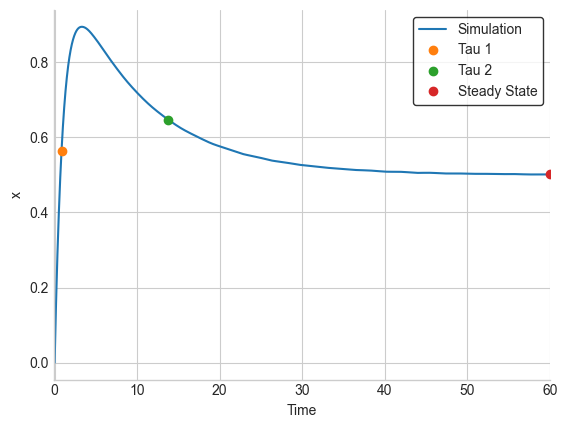

In [5]:
k1, k2, k3, k4, Ac, xi = 1, 1, 0.05, 0.05, 1, 0

# Plot ODE +  Stats
sol = simulator(k1, k2, k3, k4, Ac, xi)
plt.plot(sol.t, sol.y[0], label="Simulation")

stats = calculate_summary_statistics(sol.y[0], dt)
print(stats)

# If we return Xpeak:
try:
    plt.plot(stats[0], stats[3]*0.63, 'o', label="Tau 1", markersize=6)
    plt.plot(stats[1], (stats[2] + (stats[3] - stats[2])*0.37), 'o', label="Tau 2", markersize=6)
except:
    pass

plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(0-0.1, tf)
plt.plot(tf, stats[2], 'o', label="Steady State", markersize=6)
plt.legend(frameon=True, facecolor="white", edgecolor="black")
plt.show()

In [6]:
def simulation_wrapper(params):
    """
    Returns summary statistics from the model results using `params`.

    Summarizes the output of the simulator and converts it to `torch.Tensor`.
    """
    obs = simulator(params[0], params[1], params[2], params[3], params[4], params[5]) #y[0] = x
    stats = torch.as_tensor(calculate_summary_statistics(obs.y[0], dt))
    return stats

In [7]:
# Load simulations
params, x = torch.load('simulations_500k_restricted.pt')
print("Simulations loaded")

# Calculate summary statistics of each simulation
stats = np.empty((len(x), 4), dtype="float32")
for i in tqdm(range(len(params))):
    stats[i] = calculate_summary_statistics(x[i][0].numpy(), dt)

Simulations loaded


100%|██████████| 500000/500000 [03:11<00:00, 2608.60it/s]


In [8]:
inference = SNPE()
inference = inference.append_simulations(params, torch.from_numpy(stats))
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 134 epochs.

### NFBL Inference

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

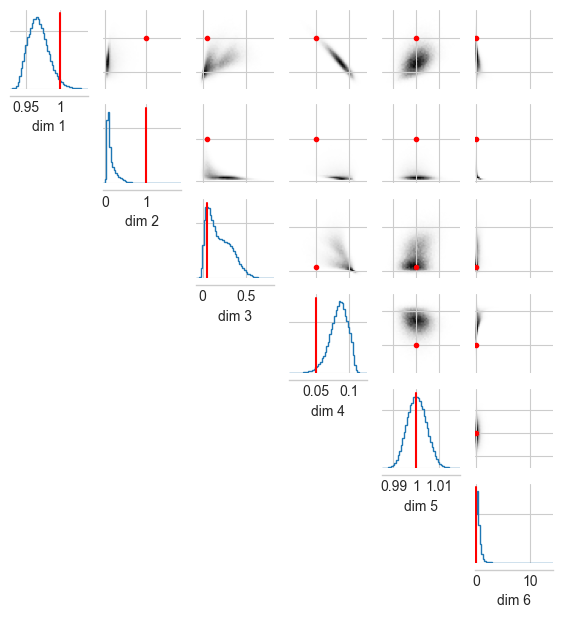

In [9]:
k1, k2, k3, k4, Ac, xi = 1, 1, 0.05, 0.05, 1, 0
sol = simulator(k1, k2, k3, k4, Ac, xi)
observation_summary_statistics = calculate_summary_statistics(sol.y[0], dt)
samples = posterior.sample((100000,), x=observation_summary_statistics)

fig, axes = analysis.pairplot(
    samples,
    figsize=(7, 7),
    points=true_params_nfbl,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

 --- Real parameters --- 
1 1 0.05 0.05 1 0
 --- Estimated Parameters --- 
[[0.96116525 0.12094991 0.0957103  0.09008825 0.9978865  0.33563852]]
 --- Real attributes --- 
[ 0.84       13.73        0.50102226  0.89384105]
 --- Estimated attributes --- 
tensor([ 0.8400, 13.9500,  0.5038,  0.8927], dtype=torch.float64)


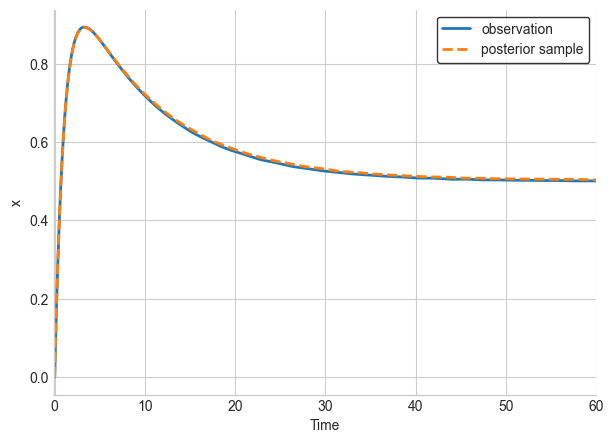

In [10]:
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()
fig = plt.figure(figsize=(7, 5))

# Plot observation
t = observation_trace.t
y_obs = observation_trace.y[0]
plt.plot(t, y_obs, lw=2, label="observation")
print(" --- Real parameters --- ")
print(k1, k2, k3, k4, Ac, xi)
print(" --- Estimated Parameters --- ")
print(posterior_sample)
print(" --- Real attributes --- ")
print(observation_summary_statistics)
print(" --- Estimated attributes --- ")
print(simulation_wrapper(posterior_sample[0]))


# Simulate and plot samples from the posterior
x = simulator(posterior_sample[0][0], posterior_sample[0][1], posterior_sample[0][2], posterior_sample[0][3], posterior_sample[0][4], posterior_sample[0][5])
plt.plot(x.t, x.y[0], "--", lw=2, label="posterior sample")

plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(0-0.1, tf)
plt.legend(frameon=True, facecolor="white", edgecolor="black")

plt.xlabel("Time")
plt.ylabel("x")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

### IFFL Inference

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

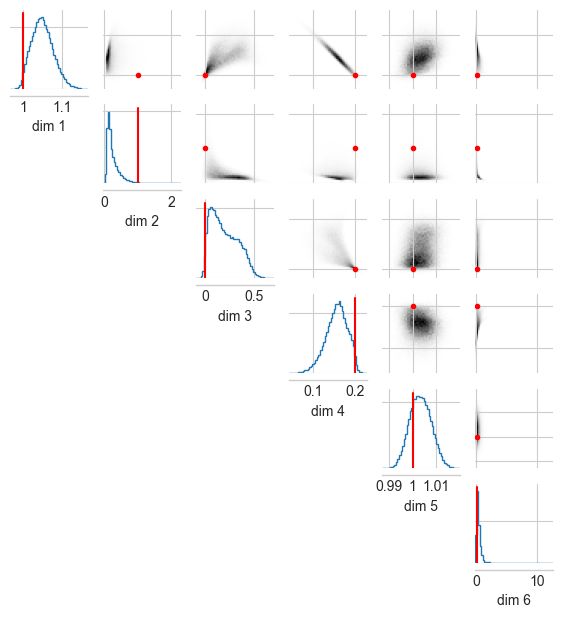

In [11]:
k1, k2, k3, k4, Ac, xi = 1, 1, 0, 0.2, 1, 0.1
sol = simulator(k1, k2, k3, k4, Ac, xi)
observation_summary_statistics = calculate_summary_statistics(sol.y[0], dt)
samples = posterior.sample((100000,), x=observation_summary_statistics)

fig, axes = analysis.pairplot(
    samples,
    figsize=(7, 7),
    points=true_params_iffl,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

 --- Real parameters --- 
1 1 0 0.2 1 0.1
 --- Estimated Parameters --- 
[[1.0112886  0.09033187 0.08796573 0.19095196 1.0010189  1.0073795 ]]
 --- Real attributes --- 
[0.73       8.79       0.49966158 0.78861872]
 --- Estimated attributes --- 
tensor([0.7300, 8.7600, 0.4974, 0.7874], dtype=torch.float64)


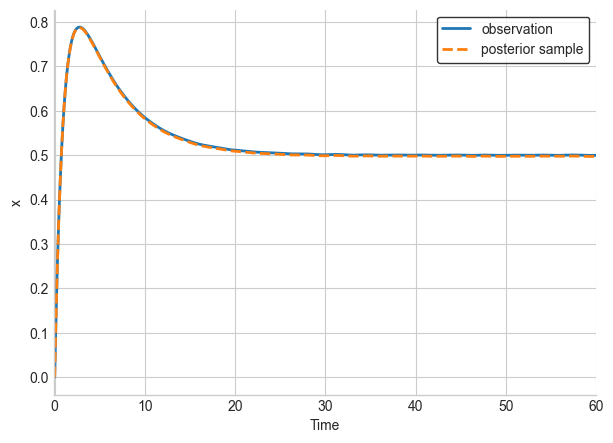

In [12]:
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()
fig = plt.figure(figsize=(7, 5))

# Plot observation
t = observation_trace.t
y_obs = sol.y[0]
plt.plot(t, y_obs, lw=2, label="observation")
print(" --- Real parameters --- ")
print(k1, k2, k3, k4, Ac, xi)
print(" --- Estimated Parameters --- ")
print(posterior_sample)
print(" --- Real attributes --- ")
print(observation_summary_statistics)
print(" --- Estimated attributes --- ")
print(simulation_wrapper(posterior_sample[0]))


# Simulate and plot samples from the posterior
x = simulator(posterior_sample[0][0], posterior_sample[0][1], posterior_sample[0][2], posterior_sample[0][3], posterior_sample[0][4], posterior_sample[0][5])
plt.plot(x.t, x.y[0], "--", lw=2, label="posterior sample")

plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(0-0.1, tf)
plt.legend(frameon=True, facecolor="white", edgecolor="black")

plt.xlabel("Time")
plt.ylabel("x")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

In [13]:
import dill
dill.dump_session('notebook_sbi_flexible_noYattributes.db')

c:\Users\German\.julia\conda\3\x86_64\lib\site-packages\sbi\inference\base.py:427: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  warn(
